In [1]:
# import libraries
import os
from path import Path
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
#Reading the Data into the Dataframe

In [3]:
filepath = "./Resources/austinHousingData.csv"
housing_raw_df = pd.read_csv(filepath)
housing_raw_df.head()

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,...,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
0,111373431,pflugerville,14424 Lake Victor Dr,78660,"14424 Lake Victor Dr, Pflugerville, TX 78660 i...",30.430632,-97.663078,1.98,2,True,...,1,1,1.266667,2.666667,1063,14,3.0,4,2,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...
1,120900430,pflugerville,1104 Strickling Dr,78660,Absolutely GORGEOUS 4 Bedroom home with 2 full...,30.432673,-97.661697,1.98,2,True,...,1,1,1.400000,2.666667,1063,14,2.0,4,1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f...
2,2084491383,pflugerville,1408 Fort Dessau Rd,78660,Under construction - estimated completion in A...,30.409748,-97.639771,1.98,0,True,...,1,1,1.200000,3.000000,1108,14,2.0,3,1,2084491383_a2ad649e1a7a098111dcea084a11c855-p_...
3,120901374,pflugerville,1025 Strickling Dr,78660,Absolutely darling one story home in charming ...,30.432112,-97.661659,1.98,2,True,...,1,1,1.400000,2.666667,1063,14,2.0,3,1,120901374_b469367a619da85b1f5ceb69b675d88e-p_f...
4,60134862,pflugerville,15005 Donna Jane Loop,78660,Brimming with appeal & warm livability! Sleek ...,30.437368,-97.656860,1.98,0,True,...,1,1,1.133333,4.000000,1223,14,3.0,3,2,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f.jpg


In [4]:
housing_raw_df.nunique() # reading the uniques values in each column

zpid                          15171
city                              9
streetAddress                 15164
zipcode                          48
description                   15133
latitude                      14410
longitude                     12480
propertyTaxRate                   3
garageSpaces                     14
hasAssociation                    2
hasCooling                        2
hasGarage                         2
hasHeating                        2
hasSpa                            2
hasView                           2
homeType                         10
parkingSpaces                    14
yearBuilt                       115
latestPrice                    2365
numPriceChanges                  22
latest_saledate                 958
latest_salemonth                 12
latest_saleyear                   4
latestPriceSource               225
numOfPhotos                     151
numOfAccessibilityFeatures        8
numOfAppliances                  13
numOfParkingFeatures        

In [5]:
housing_raw_df.latestPriceSource

0        Coldwell Banker United, Realtors - South Austin
1                                         Agent Provided
2                                         Agent Provided
3                                         Agent Provided
4                                         Agent Provided
                              ...                       
15166                                     Agent Provided
15167                                     Agent Provided
15168                                               ABOR
15169                                    Broker Provided
15170                                      Realty Austin
Name: latestPriceSource, Length: 15171, dtype: object

In [6]:
# Drop the columns which are not useful for analysis
drop_cols_list = ["homeImage", "numOfPhotos", "numPriceChanges", "description" , "streetAddress", "latitude", "longitude", "latestPriceSource"]
housing_df = housing_raw_df.drop(columns=drop_cols_list)
housing_df = housing_df.set_index("zpid")
housing_df.head(5)

,city,zipcode,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,...,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories
zpid,,,,,,,,,,,,,,,,,,,,,
111373431,pflugerville,78660,1.98,2,True,True,True,True,False,False,...,0,1,1,1.266667,2.666667,1063,14,3.0,4,2
120900430,pflugerville,78660,1.98,2,True,True,True,True,False,False,...,0,1,1,1.400000,2.666667,1063,14,2.0,4,1
2084491383,pflugerville,78660,1.98,0,True,True,False,True,False,False,...,2,1,1,1.200000,3.000000,1108,14,2.0,3,1
120901374,pflugerville,78660,1.98,2,True,True,True,True,False,False,...,0,1,1,1.400000,2.666667,1063,14,2.0,3,1
60134862,pflugerville,78660,1.98,0,True,True,False,True,False,False,...,0,1,1,1.133333,4.000000,1223,14,3.0,3,2


In [7]:
housing_df.dtypes # checking datatypes of all the columns

city                           object
zipcode                         int64
propertyTaxRate               float64
garageSpaces                    int64
hasAssociation                   bool
hasCooling                       bool
hasGarage                        bool
hasHeating                       bool
hasSpa                           bool
hasView                          bool
homeType                       object
parkingSpaces                   int64
yearBuilt                       int64
latestPrice                   float64
latest_saledate                object
latest_salemonth                int64
latest_saleyear                 int64
numOfAccessibilityFeatures      int64
numOfAppliances                 int64
numOfParkingFeatures            int64
numOfPatioAndPorchFeatures      int64
numOfSecurityFeatures           int64
numOfWaterfrontFeatures         int64
numOfWindowFeatures             int64
numOfCommunityFeatures          int64
lotSizeSqFt                   float64
livingAreaSq

In [8]:
housing_df.dropna()
print(housing_df.count()) # checking if the count of the columns are all same

city                          15171
zipcode                       15171
propertyTaxRate               15171
garageSpaces                  15171
hasAssociation                15171
hasCooling                    15171
hasGarage                     15171
hasHeating                    15171
hasSpa                        15171
hasView                       15171
homeType                      15171
parkingSpaces                 15171
yearBuilt                     15171
latestPrice                   15171
latest_saledate               15171
latest_salemonth              15171
latest_saleyear               15171
numOfAccessibilityFeatures    15171
numOfAppliances               15171
numOfParkingFeatures          15171
numOfPatioAndPorchFeatures    15171
numOfSecurityFeatures         15171
numOfWaterfrontFeatures       15171
numOfWindowFeatures           15171
numOfCommunityFeatures        15171
lotSizeSqFt                   15171
livingAreaSqFt                15171
numOfPrimarySchools         

In [9]:
housing_df.isnull().sum() # checking still if there any columns with null

city                          0
zipcode                       0
propertyTaxRate               0
garageSpaces                  0
hasAssociation                0
hasCooling                    0
hasGarage                     0
hasHeating                    0
hasSpa                        0
hasView                       0
homeType                      0
parkingSpaces                 0
yearBuilt                     0
latestPrice                   0
latest_saledate               0
latest_salemonth              0
latest_saleyear               0
numOfAccessibilityFeatures    0
numOfAppliances               0
numOfParkingFeatures          0
numOfPatioAndPorchFeatures    0
numOfSecurityFeatures         0
numOfWaterfrontFeatures       0
numOfWindowFeatures           0
numOfCommunityFeatures        0
lotSizeSqFt                   0
livingAreaSqFt                0
numOfPrimarySchools           0
numOfElementarySchools        0
numOfMiddleSchools            0
numOfHighSchools              0
avgSchoo

### Exploratory Data Analysis between LivingAreaSqft vs latest Price

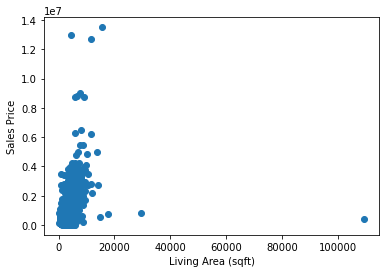

In [10]:
# scatter plot between Sales Price vs Living Square ft
plt.scatter(housing_df.livingAreaSqFt,housing_df.latestPrice)
plt.xlabel('Living Area (sqft)')
plt.ylabel('Sales Price')
plt.show()

## Linear Model  between LivingArea (sqft) vs SalePrice

In [11]:
X = housing_df.livingAreaSqFt.values.reshape(-1,1) # reshape two arguments
# first arg is number of rows  -1 means , number of rows unspecified
#second arg is number of columns (independent variables)

In [12]:
X[:5]

array([[2601.],
       [1768.],
       [1478.],
       [1678.],
       [2132.]])

In [13]:
X.shape

(15171, 1)

In [14]:
y = housing_df.latestPrice
model = LinearRegression() # model instantiated

In [15]:
model.fit(X,y)

LinearRegression()

In [16]:
y_pred = model.predict(X)
print(y_pred.shape)

(15171,)


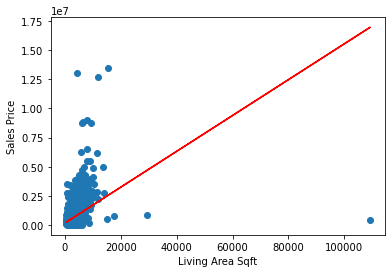

In [17]:
plt.scatter(X,y)
plt.plot(X,y_pred, color='red')
plt.xlabel("Living Area Sqft")
plt.ylabel("Sales Price")
plt.show()

In [18]:
print(model.coef_)
print(model.intercept_)

[153.53008865]
173723.66953146114


## Exploratory Analysis Between YearBuilt vs Sale Price

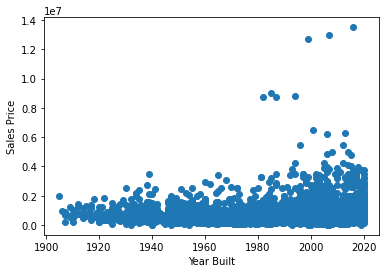

In [19]:
plt.scatter(housing_df.yearBuilt,housing_df.latestPrice)
plt.xlabel('Year Built')
plt.ylabel('Sales Price')
plt.show()

## Linear Model  between Year Built vs SalePrice

In [20]:
X = housing_df.yearBuilt.values.reshape(-1,1) # reshape two arguments

In [21]:
y = housing_df.latestPrice
model = LinearRegression() # model instantiated
model.fit(X,y)

LinearRegression()

In [22]:
y_pred = model.predict(X)
print(y_pred.shape)

(15171,)


[1253.58771797]
-1980060.0581185068


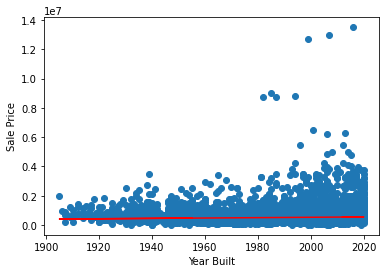

In [23]:
print(model.coef_)
print(model.intercept_)

plt.scatter(X,y)
plt.plot(X,y_pred, color='red')
plt.xlabel("Year Built")
plt.ylabel("Sale Price")
plt.show()